### GroundingDINO with Segment Anything (SAM) for Text-Based Mask Generation

In this notebook, we will combine two powerful models—Grounding DINO (Self-Distillation with No Labels) and SAM—to perform text-based mask generation.  
- First, we will use Grounding DINO to generate bounding boxes based on text prompts.
- Then, we will pass these bounding boxes to SAM to generate the corresponding segmentation masks.

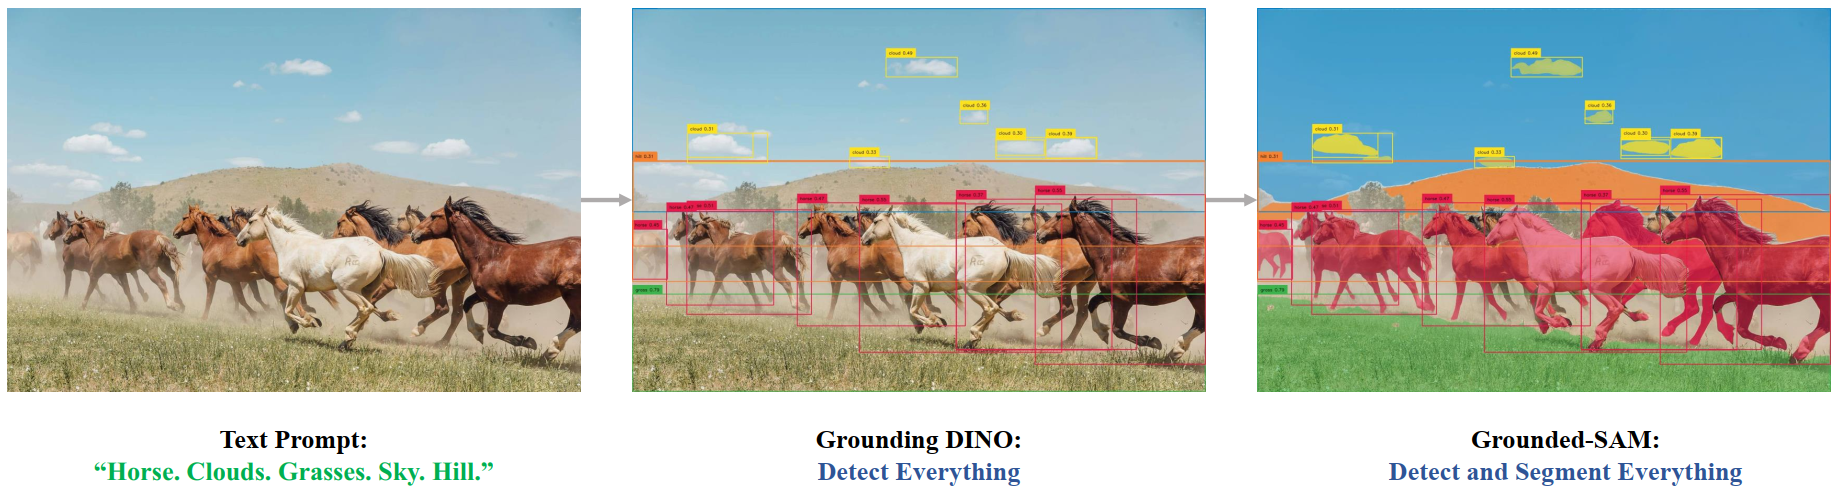

### **References**
**Models**  
- [Grounding DINO — HuggingFace Docs](https://huggingface.co/docs/transformers/model_doc/grounding-dino)  
- [SAM — HuggingFace Docs](https://huggingface.co/docs/transformers/model_doc/sam)  
- [Grounded SAM: Assembling Open-World Models for Diverse Visual Tasks](https://arxiv.org/abs/2401.14159)  

**Libraries**  
- [Plotly Documentation](https://plotly.com/python/getting-started/)  
- [Plotly Express](https://plotly.com/python/plotly-express/)  

In [9]:
import random
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple

import requests
import cv2
import torch
import numpy as np
from PIL import Image

from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go

from transformers import AutoModelForMaskGeneration, AutoProcessor, pipeline

### Utilis Class to Store Result Information

We will store the detection results from Grounding DINO in a dedicated Python dataclass.

In [2]:
@dataclass
class BoundingBox:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def xyxy(self) -> List[float]:
        return [self.xmin, self.ymin, self.xmax, self.ymax]

@dataclass
class DetectionResult:
    score: float
    label: str
    box: BoundingBox
    mask: Optional[np.array] = None

    @classmethod
    def from_dict(cls, detection_dict: Dict) -> 'DetectionResult':
        return cls(
            score=detection_dict['score'],
            label=detection_dict['label'],
            box=BoundingBox(
                xmin=detection_dict['box']['xmin'],
                ymin=detection_dict['box']['ymin'],
                xmax=detection_dict['box']['xmax'],
                ymax=detection_dict['box']['ymax'],
            ),
        )

### Utilities for Visualization

We define several utility functions to overlay the detection results from Grounding DINO on top of an image.

- In the method `cv2.findContours`, we use the `cv2.RETR_EXTERNAL` mode, which retrieves only the outermost contours of objects in the image. This mode ignores any contours that are nested within others and focuses solely on the external boundaries of the detected shapes. We also use the `cv2.CHAIN_APPROX_SIMPLE` method, which simplifies the contour representation by removing unnecessary points and retaining only the essential points that define the contour’s shape.

**References:**
- [Contours — OpenCV Documentation](https://docs.opencv.org/5.0.0-alpha/d4/d73/tutorial_py_contours_begin.html)
- [Contours in OpenCV — Scaler](https://www.scaler.com/topics/contours-in-opencv/)

In [15]:
def annotate(image: Union[Image.Image, np.ndarray], detection_results: List[DetectionResult]) -> np.ndarray:

    # Convert PIL Image to OpenCV format
    image_cv2 = np.array(image) if isinstance(image, Image.Image) else image
    image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_RGB2BGR)

    # iterate over detections and add bounding boxes and masks
    for detection in detection_results:
        label = detection.label
        score = detection.score
        box = detection.box
        mask = detection.mask

        # Sample a random color for each detection
        color = np.random.randint(0, 256, size=3)

        # draw bounding box
        cv2.rectangle(image_cv2, (box.xmin, box.ymin), (box.xmax, box.ymax), color.tolist(), 2)
        cv2.putText(image_cv2, f"{label} {score: .2f}", (box.xmin, box.ymin -10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)

        # if mask is unvailable, apply it
        if mask is not None:
            # convert mask to uint8
            mask_uint8 = (mask*255).astype(np.uint8)
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image_cv2, contours, -1, color.tolist(), 2)

    return cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

def plot_detections(image: Union[Image.Image, np.ndarray],
                                detections: List[DetectionResult],
                                save_name: Optional[str] = None) -> None:
    '''
    Plot the detection of image

    Args:
        - image: image of the object
        - detections: detection result of the image by model
        - save_name: name of the image to save
    '''
    annotated_image = annotate(image, detections)
    plt.imshow(annotated_image)
    plt.axis("off")
    if save_name:
        plt.savefig(save_name, bbox_inches="tight")
    plt.show()

In [4]:
def random_named_css_colors(num_colors: int) -> List[str]:
    # list of css color names
    named_css_colors =  [
        'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond',
        'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue',
        'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey',
        'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
        'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue',
        'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite',
        'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory',
        'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow',
        'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray',
        'lightslategrey', 'lightsteelblue', 'lightyellow', 'lime', 'limegreen', 'linen', 'magenta', 'maroon', 'mediumaquamarine',
        'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise',
        'mediumvioletred', 'midnightblue', 'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy', 'oldlace', 'olive',
        'olivedrab', 'orange', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip',
        'peachpuff', 'peru', 'pink', 'plum', 'powderblue', 'purple', 'rebeccapurple', 'red', 'rosybrown', 'royalblue', 'saddlebrown',
        'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue', 'slategray', 'slategrey',
        'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'white',
        'whitesmoke', 'yellow', 'yellowgreen'
    ]
    # Sample random named CSS colors
    return random.sample(named_css_colors, min(num_colors, len(named_css_colors)))

def plot_detections_plotly(
        image: np.ndarray,
        detections: List[DetectionResult],
        class_colors: Optional[Dict[str, str]] = None) -> None:
    # if class_colors is not provided, generate the random colors for each class
    if class_colors is None:
        num_detections = len(detections)
        colors = random_named_css_colors(num_detections)
        class_colors = {}
        for i in range(num_detections):
            class_colors[i] = colors[i]

    fig = px.imshow(image)

    # add bounding boxes
    shapes = []
    annotations = []
    for idx, detection in enumerate(detections):
        label = detection.label
        box = detection.box
        score = detection.score
        mask = detection.mask

        polygon = mask_to_polygon(mask)

        fig.add_trace(go.Scatter(
            x=[point[0] for point in polygon] + [polygon[0][0]],
            y=[point[1] for point in polygon] + [polygon[0][1]],
            mode="lines",
            line=dict(color=class_colors[idx], width=2),
            fill="toself",
            name=f"{label}: {score:.2f}"
        ))

        xmin, ymin, xmax, ymax = box.xyxy
        shape = [dict(
            type="rect",
            xref="x", yref="y",
            x0=xmin, y0=ymin,
            x1=xmax, y1=ymax,
            line=dict(color=class_colors)
        )]

        annotation = [dict(
            x=(xmin  + xmax) // 2, y=(ymin + ymax) // 2,
            xref="x", yref="y",
            text=f"{label}: {score:.2f}",
        )]

        shapes.append(shape)
        annotations.append(annotation)

    # update layout
    button_shapes = [dict(label="None", method="relayout", args=["shapes", []])]
    button_shapes = button_shapes + [
        dict(label=f"Detection {idx + 1}", method="relayout",
             args=["shapes", shape]) for idx, shape in enumerate(shapes)
    ]
    button_shapes = button_shapes + [dict(label="All", method="relayout", args=["shapes", sum(shapes, [])])]

    fig.update_layout(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        showlegend=True,
        updatemenus=[dict(type="buttons", direction="up", buttons=button_shapes)],
        legend=dict(orientation="h", yanchor="bottom", y=1.01, xanchor="right", x=1)
    )

    # show plot
    fig.show()

### Utils

**References**
- [Basic Geometric Drawing -- OpenCV docs for fillPoly](https://docs.opencv.org/5.0.0-alpha/d3/d96/tutorial_basic_geometric_drawing.html)

In [5]:
def mask_to_polygon(mask: np.ndarray) -> List[List[int]]:
    """
    Convert a binary mask to a polygonal representation by finding its largest contour.

    Args:
        - mask (np.ndarray): Binary mask image (1-channel)

    Returns:
        - List[List[int]]: List of (x, y) vertices of the largest contour
    """
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Extract the vertices of the largest contour
    polygon = largest_contour.reshape(-1, 2).tolist()
    return polygon

def polygon_to_mask(polygon: List[Tuple[int, int]], image_shape: Tuple[int, int]) -> np.ndarray:
    """
    Convert a polygon (list of vertices) into a binary mask.

    Args:
        - polygon (List[Tuple[int, int]]): List of (x, y) coordinates representing the vertices of the polygon
        - image_shape (Tuple[int, int]): Shape of the image (height, width)

    Returns:
        - np.ndarray: Binary mask with the polygon filled (1)
    """
    # Create an empty mask
    mask = np.zeros(image_shape, dtype=np.uint8)

    # Convert polygon to a NumPy array of points
    pts = np.array(polygon, dtype=np.int32)

    # Fill the polygon with white color (255)
    cv2.fillPoly(mask, [pts], color=255)
    return mask

def load_image(image_str: str) -> Image.Image:
    """
    Load an image from a file path or URL.

    Args:
        - image_str (str): File path or URL of the image

    Returns:
        - Image.Image: Loaded image as a PIL Image
    """
    if image_str.startswith("http"):
        # Load image from URL
        image = Image.open(requests.get(image_str, stream=True).raw).convert("RGB")
    else:
        # Load image from local file
        image = Image.open(image_str).convert("RGB")
    return image

def get_boxes(results: 'DetectionResult') -> List[List[List[float]]]:
    """
    Extract bounding boxes from the detection results.

    Args:
        - results (DetectionResult): Detection results object containing the boxes

    Returns:
        - List[List[List[float]]]: List of bounding boxes in XYXY format
    """
    boxes = [result.box.xyxy for result in results]
    return [boxes]

def refine_masks(masks: torch.BoolTensor, polygon_refinement: bool = False) -> List[np.ndarray]:
    """
    Refine segmentation masks by optionally converting to polygons and refining them.

    Args:
        - masks (torch.BoolTensor): Input masks tensor (batch, channels, height, width)
        - polygon_refinement (bool): Whether to perform polygon refinement on masks

    Returns:
        - List[np.ndarray]: List of refined masks as NumPy arrays
    """
    # Convert masks tensor to a binary mask (batch, height, width)
    masks = masks.cpu().float()
    masks = masks.permute(0, 2, 3, 1).mean(axis=-1)  # Convert to (batch, height, width)
    masks = (masks > 0).int()  # Threshold to create binary mask (0 or 1)
    masks = masks.numpy().astype(np.uint8)
    masks = list(masks)

    # Apply polygon refinement if specified
    if polygon_refinement:
        for idx, mask in enumerate(masks):
            shape = mask.shape
            polygon = mask_to_polygon(mask)
            mask = polygon_to_mask(polygon, shape)
            masks[idx] = mask

    return masks

### Grounded Segment Anything (SAM)
Its now time to define the grounded SAM approch
The approach is very simple

1. Use **Grounding DINO** to detect  agiven set of texts in the image, The output is a set of bounding boxes.
2. Prompt Segment Anything(SAM) with bounding boxes, for which the model will output segmentation masks.

In [6]:
def detect(image: Image.Image,
           labels: List[str],
           threshold: float = 0.3,
           detector_id: Optional[str] = None) -> List[Dict[str, Any]]:
    """
    Detects a set of labels in an image using Grounding DINO in a zero-shot fashion.

    Args:
        image (Image.Image): The input image.
        labels (List[str]): List of labels to detect.
        threshold (float): Confidence threshold for detection.
        detector_id (Optional[str]): The model identifier for the object detector.

    Returns:
        List[Dict[str, Any]]: List of detection results.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    detector_id = detector_id or "IDEA-Research/grounding-dino-tiny"
    object_detector = pipeline(model=detector_id, task="zero-shot-object-detection", device=device)

    # Ensure labels end with a period for consistency
    labels = [label if label.endswith(".") else label + "." for label in labels]

    results = object_detector(image, candidate_labels=labels, threshold=threshold)
    return [DetectionResult.from_dict(result) for result in results]


def segment(image: Image.Image,
            detection_results: List[Dict[str, Any]],
            polygon_refinement: bool = False,
            segmenter_id: Optional[str] = None) -> List[DetectionResult]:
    """
    Segments the image based on detected objects, generating masks using Segment Anything (SAM).

    Args:
        image (Image.Image): The input image.
        detection_results (List[Dict[str, Any]]): Detection results (bounding boxes).
        polygon_refinement (bool): Whether to apply polygon refinement to the masks.
        segmenter_id (Optional[str]): The model identifier for the segmenter.

    Returns:
        List[DetectionResult]: List of detection results with associated masks.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    segmenter_id = segmenter_id or "facebook/sam-vit-base"  # Default segmenter if none specified

    segmenter = AutoModelForMaskGeneration.from_pretrained(segmenter_id).to(device)
    processor = AutoProcessor.from_pretrained(segmenter_id)

    boxes = get_boxes(detection_results)
    inputs = processor(images=image, input_boxes=boxes, return_tensors="pt").to(device)

    # Generate masks from the segmenter model
    outputs = segmenter(**inputs)
    masks = processor.post_process_masks(
        masks=outputs.pred_masks,
        original_sizes=inputs.original_sizes,
        reshaped_input_sizes=inputs.reshaped_input_sizes
    )[0]

    # Optionally refine the masks
    refined_masks = refine_masks(masks, polygon_refinement)

    # Assign refined masks to the detection results
    for detection_result, mask in zip(detection_results, refined_masks):
        detection_result.mask = mask

    return detection_results


def grounded_segmentation(image: Union[Image.Image, str],
                          labels: List[str],
                          threshold: float = 0.3,
                          polygon_refinement: bool = False,
                          detector_id: Optional[str] = None,
                          segmenter_id: Optional[str] = None) -> Tuple[np.ndarray, List[DetectionResult]]:
    """
    Perform grounded segmentation on an image by detecting objects and generating segmentation masks.

    Args:
        image (Union[Image.Image, str]): The input image (can be a path or an image object).
        labels (List[str]): List of labels to detect in the image.
        threshold (float): Confidence threshold for detection.
        polygon_refinement (bool): Whether to apply polygon refinement to the segmentation masks.
        detector_id (Optional[str]): The model identifier for the object detector.
        segmenter_id (Optional[str]): The model identifier for the segmenter.

    Returns:
        Tuple[np.ndarray, List[DetectionResult]]: A tuple containing the image (as a NumPy array) and the detection results.
    """
    if isinstance(image, str):
        image = load_image(image)

    # Perform object detection
    detections = detect(image, labels, threshold, detector_id)

    # Perform segmentation on the detected objects
    detections = segment(image, detections, polygon_refinement, segmenter_id)

    return np.array(image), detections

### Inferences
Let's demonstrate Grounded SAM using one of our favorite images: the cats image from the COCO dataset.

**References**
- [Grounding DINO Tiny -- HuggingFace Model](https://huggingface.co/IDEA-Research/grounding-dino-tiny): Open-set object detection model
- [SAM -- HuggingFace Model](https://huggingface.co/facebook/sam-vit-base): Segmentation model

In [7]:
image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
labels = ["a cat", "a remote control"]
threshold = 0.3

detector_id = "IDEA-Research/grounding-dino-tiny"
segmenter_id = "facebook/sam-vit-base"

In [10]:
image_array, detections = grounded_segmentation(
    image=image_url,
    labels=labels,
    threshold=threshold,
    polygon_refinement=True,
    detector_id=detector_id,
    segmenter_id=segmenter_id
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

#### Visualize the results

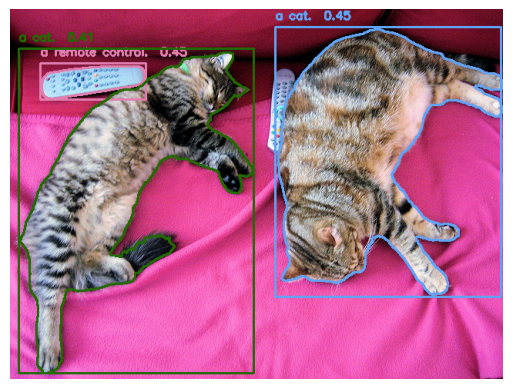

In [16]:
plot_detections(image_array, detections, "cute_cats.png")

In [17]:
plot_detections_plotly(image_array, detections)